<a href="https://colab.research.google.com/github/EmiLaPiola/TP-automatico-/blob/main/Tp_heuristicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import files
import zipfile
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# PREPROCESAMIENTO DE DATOS

# Subí el archivo "dataset.zip"
uploaded = files.upload()

# Descomprimir en el directorio actual
with zipfile.ZipFile("datasetFinal.zip", "r") as zip_ref:
    zip_ref.extractall(".")  # Extrae "dataset_enviar/" en raíz

# Mostrar contenido de la carpeta extraída
print("Contenido de 'datasetFinal':")
print(os.listdir("datasetFinal"))


# Paso 2: Descomprimir "dataset.zip", que contiene la carpeta "dataset_enviar"

zip_path = "datasetFinal.zip"  # Nombre del archivo que subiste

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")  # Extrae la carpeta "dataset_enviar" dentro del entorno


# Paso 3: Verificar el contenido descomprimido (opcional)
print("Contenido de la carpeta datasetFinal:")
print(os.listdir("datasetFinal"))

# Paso 4: Cargar grafo e instancias

# Cargar el grafo
grafo = pd.read_csv("datasetFinal/grafo.csv", header=None)

# Cargar las 10 instancias
instancias = {}
for i in range(1, 11):
    path = f"datasetFinal/instancia{i}.csv"
    instancias[i] = pd.read_csv(path, header=None)

Saving datasetFinal.zip to datasetFinal (1).zip
Contenido de 'datasetFinal':
['instancia2.csv', 'instancia6.csv', 'grafo.csv', 'instancia5.csv', 'instancia4.csv', 'instancia10.csv', 'instancia8.csv', 'instancia9.csv', 'instancia7.csv', '.DS_Store', 'instancia3.csv', 'instancia1.csv']
Contenido de la carpeta datasetFinal:
['instancia2.csv', 'instancia6.csv', 'grafo.csv', 'instancia5.csv', 'instancia4.csv', 'instancia10.csv', 'instancia8.csv', 'instancia9.csv', 'instancia7.csv', '.DS_Store', 'instancia3.csv', 'instancia1.csv']


Nodos: 1200 | Arcos: 5446


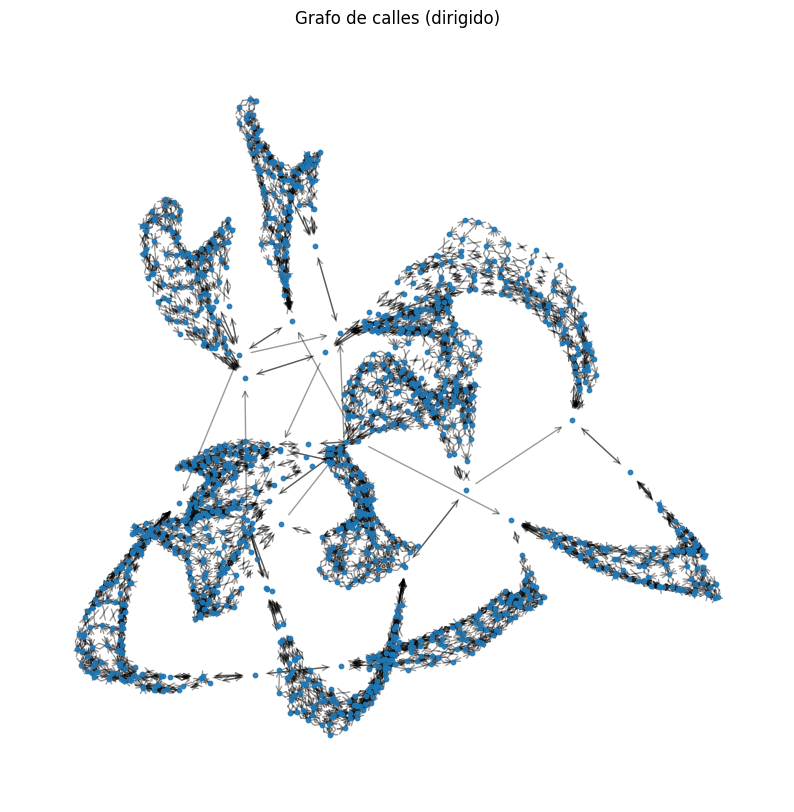

In [4]:
# Ruta corregida
GRAFO_PATH = "datasetFinal/grafo.csv"

# Cargar arcos: columnas (i, j, c_ij)
df_g = pd.read_csv(GRAFO_PATH, header=None, names=["u", "v", "w"])

# Crear grafo dirigido con pesos
G = nx.DiGraph()
for _, row in df_g.iterrows():
    G.add_edge(int(row.u), int(row.v), w=float(row.w))

print(f"Nodos: {G.number_of_nodes()} | Arcos: {G.number_of_edges()}")

# Layout (no basado en coordenadas geográficas)
pos = nx.spring_layout(G, seed=33)

# Dibujar el grafo
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=10, alpha=0.4)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color="#1f77b4", alpha=0.9)
# nx.draw_networkx_labels(G, pos, font_size=8)  # Descomentar si querés ver los números de nodo

plt.title("Grafo de calles (dirigido)")
plt.axis("off")
plt.show()

# Veamos como es la instancia 1

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


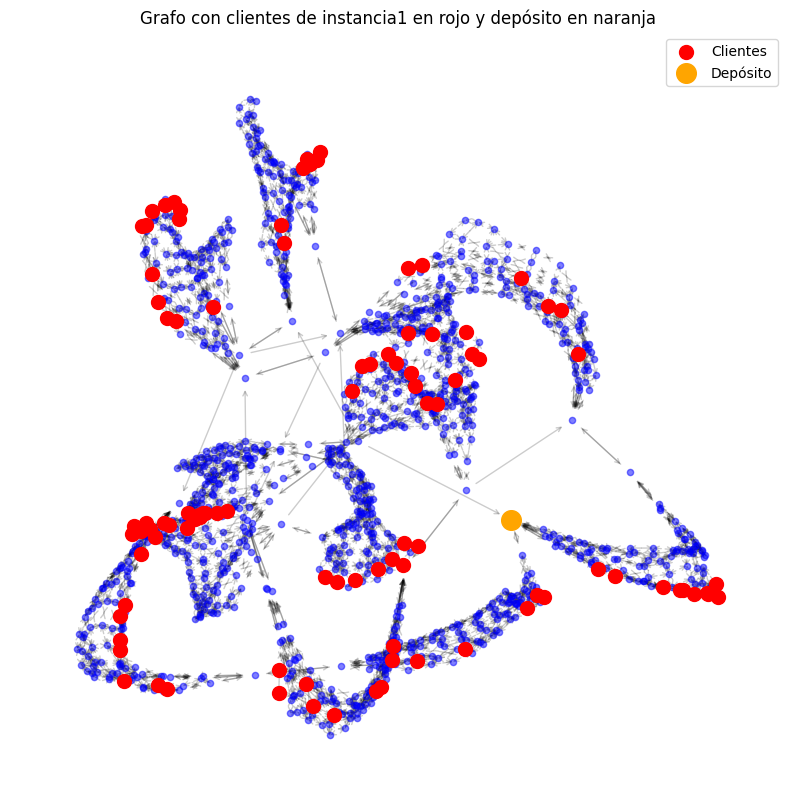

In [6]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- Paths corregidos ---
GRAFO_PATH = "datasetFinal/grafo.csv"
INST_PATH = "datasetFinal/instancia1.csv"
DEPOT = 0  # nodo de la empresa

# --- Cargar grafo ---
df_g = pd.read_csv(GRAFO_PATH, header=None, names=["u","v","w"])
G = nx.DiGraph()
for _, row in df_g.iterrows():
    G.add_edge(int(row.u), int(row.v), w=float(row.w))

# --- Cargar clientes (hogares) ---
df_inst = pd.read_csv(INST_PATH, header=None, names=["home","radius"])
clientes = df_inst["home"].astype(int).tolist()

# --- Layout del grafo (si no hay coordenadas reales) ---
pos = nx.spring_layout(G, seed=33)

# --- Dibujo ---
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos, node_size=20, node_color="blue", alpha=0.5)
nx.draw_networkx_nodes(G, pos, nodelist=clientes, node_size=100, node_color="red", label="Clientes")
if DEPOT in G.nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[DEPOT], node_size=200, node_color="orange", label="Depósito")
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=8, alpha=0.2)

plt.title("Grafo con clientes de instancia1 en rojo y depósito en naranja")
plt.axis("off")
plt.legend()
plt.show()

# IDEA PRINCIPAL : “ Vamos a la casa del trabajador más cercano ”:
La heurística de construcción planteada:

- Arrancamos en el depósito (nodo 0).

- Buscamos el trabajador más cercano al nodo actual (con Dijkstra).

- Recorremos el camino más corto válido hasta su casa, lo agregamos a la ruta y sumamos ese costo para ver al final cuanto nos costo todo el viaje.

- Marcamos al trabajador como atendido y repetimos desde esa casa hacia el siguiente más cercano.

- Al final la combi vuelve al depósito.

Porque creemos que es clave:

Hacemos un recorrido greedy: simplemente usamos Dijkstra desde el nodo actual y elegimos al cliente más cercano.

Simple de mejorar después con 2-opt, simulated annealing, etc.

Si despues lo combinamos con "solo ir a nodos desde los que el cliente puede caminar", podemos dejar de visitar una casa exacta y en cambio pasar por un nodo dentro de su ri.

# Fase de construcción (armar una solución inicial).

Trabajadores totales: 97
Levantados: 97
Costo total (suma de w): 16460.131
Ruta (nodos):
[0, 115, 474, 314, 143, 314, 243, 790, 553, 1119, 948, 419, 371, 741, 1072, 1017, 9, 1048, 9, 801, 665, 876, 917, 721, 147, 717, 1151, 751, 1051, 412, 1027, 610, 447, 458, 1130, 453, 931, 245, 361, 558, 865, 930, 985, 775, 363, 96, 306, 1006, 365, 25, 365, 368, 949, 1170, 1197, 951, 185, 123, 148, 1117, 921, 1190, 342, 806, 350, 497, 61, 288, 126, 683, 838, 1104, 874, 119, 874, 431, 354, 105, 627, 578, 695, 686, 625, 582, 360, 483, 564, 338, 1066, 854, 337, 1098, 237, 940, 331, 503, 809, 722, 263, 722, 139, 91, 64, 91, 52, 1038, 848, 454, 6, 537, 1068, 831, 505, 664, 505, 831, 1068, 548, 221, 339, 624, 1100, 1188, 634, 321, 212, 321, 1133, 1060, 609, 883, 78, 1004, 684, 780, 794, 327, 898, 327, 684, 681, 475, 1049, 127, 3, 678, 478, 993, 849, 797, 272, 252, 1110, 387, 488, 1102, 559, 897, 1192, 997, 272, 252, 770, 387, 7, 547, 753, 319, 851, 18, 294, 642, 1096, 1031, 716, 1031, 742, 529, 850, 820, 

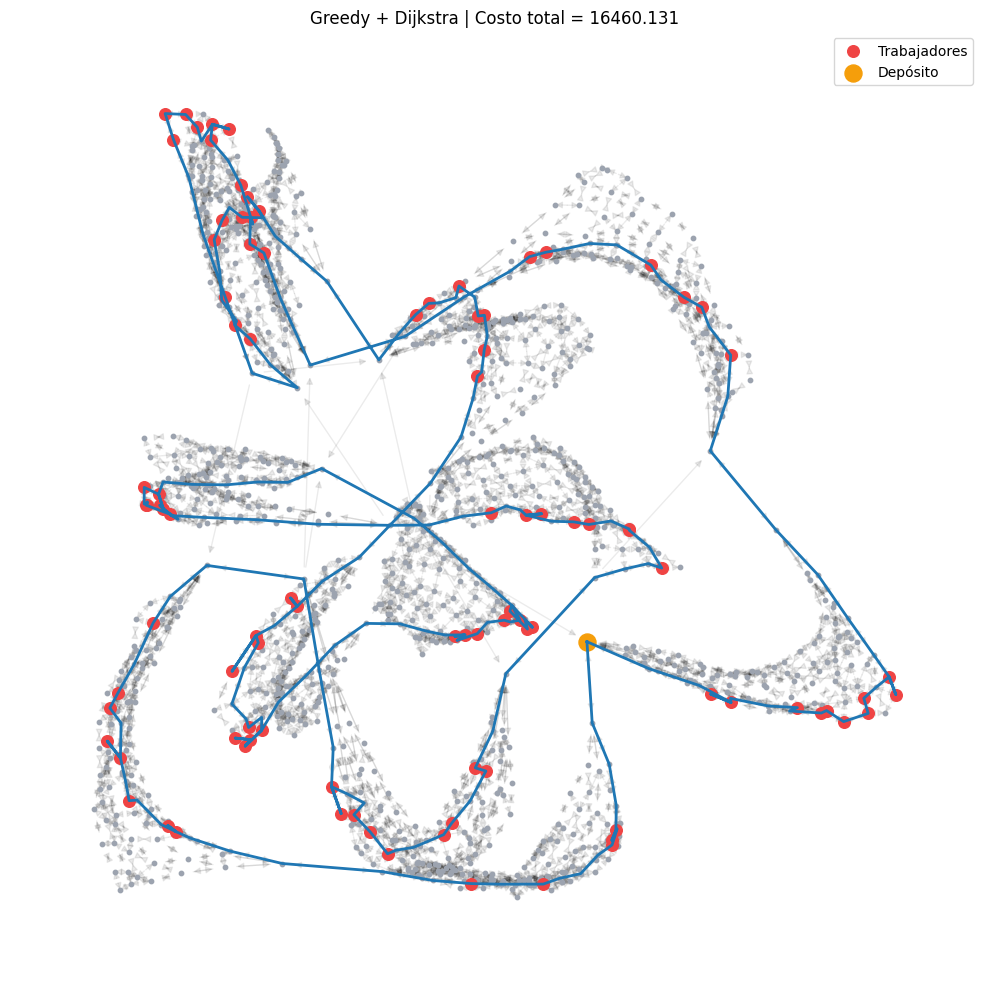

In [9]:
# PRIMERO SIN TENER EN CUENTA LAS CAMINATAS


"""
Greedy + Dijkstra (solo pesos):
- En cada iteración corre Dijkstra con corte temprano hasta el trabajador no visitado más barato.
- Concatena el camino mínimo válido y acumula el costo total.
- Al final, vuelve al depósito.
- Guarda resultados en CSV, PNG, y resultados1.txt (formato requerido).

Entradas:
  dataset_enviar/grafo.csv
  dataset_enviar/instancia1.csv

Salidas:
  ruta_dijkstra.csv
  segmentos_dijkstra.csv
  ruta_dijkstra.png (opcional)
  resultados1.txt
"""

import heapq
import random
import pandas as pd
from collections import defaultdict

# ---------------- Config ----------------
GRAFO_PATH = "datasetFinal/grafo.csv"
INST_PATH  = "datasetFinal/instancia1.csv"
DEPOT = 0
IS_DIRECTED = True
RETURN_TO_DEPOT = True
TIE_BREAK_RANDOM = True

HOME_COLS = ["home", "hogar", "node", "nodo", "cliente", "vi"]  # nombres posibles

# ---------------- Utilidades ----------------
def pick_col(df, candidates, alias="home"):
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"No se encontró columna para {alias}. Columnas: {list(df.columns)}")

def build_adj_with_weights(path, directed=True):
    df = pd.read_csv(path, header=None, names=["u", "v", "w"])
    adj = defaultdict(list)
    wmap = {}
    for _, r in df.iterrows():
        u, v, w = int(r.u), int(r.v), float(r.w)
        adj[u].append(v)
        wmap[(u, v)] = w
        if not directed:
            adj[v].append(u)
            wmap[(v, u)] = w
    return adj, wmap

def dijkstra_early(adj, wmap, src, targets_set):
    heap = [(0.0, src)]
    dist = {src: 0.0}
    parent = {src: None}
    best_cost = None
    found_targets = []

    while heap:
        du, u = heapq.heappop(heap)
        if du != dist[u]:
            continue
        if best_cost is not None and du > best_cost + 1e-12:
            break
        if u in targets_set:
            if best_cost is None:
                best_cost = du
            found_targets.append(u)
        for v in adj.get(u, []):
            nd = du + wmap[(u, v)]
            if v not in dist or nd < dist[v] - 1e-12:
                dist[v] = nd
                parent[v] = u
                heapq.heappush(heap, (nd, v))

    if not found_targets:
        return None, None, None

    target = random.choice(found_targets) if (TIE_BREAK_RANDOM and len(found_targets) > 1) else found_targets[0]

    path = []
    cur = target
    while cur is not None:
        path.append(cur)
        cur = parent[cur]
    path.reverse()
    return target, path, best_cost

# ---------------- Carga ----------------
adj, wmap = build_adj_with_weights(GRAFO_PATH, directed=IS_DIRECTED)

df_inst = pd.read_csv(INST_PATH, header=None, names=["home", "radius"])
home_col = pick_col(df_inst, HOME_COLS, alias="nodo del trabajador")
workers = [int(x) for x in df_inst[home_col].tolist()]
workers = [w for w in workers if w != DEPOT]
workers_set = set(workers)

if DEPOT not in adj and DEPOT not in workers_set:
    raise ValueError(f"El depósito {DEPOT} no existe en el grafo.")

# ---------------- Heurística ----------------
remaining = set(workers_set)
route = [DEPOT]
segments = []
unreachable = []

current = DEPOT
total_cost = 0.0

while remaining:
    target, path, seg_cost = dijkstra_early(adj, wmap, current, remaining)
    if target is None:
        unreachable.extend(sorted(list(remaining)))
        break
    route.extend(path[1:])
    segments.append({
        "from": current,
        "to": target,
        "segment_cost": float(seg_cost),
        "nodes": " ".join(map(str, path))
    })
    total_cost += float(seg_cost)
    remaining.remove(target)
    current = target

# Volver al depósito
if RETURN_TO_DEPOT:
    target, path, seg_cost = dijkstra_early(adj, wmap, current, {DEPOT})
    if target is not None:
        route.extend(path[1:])
        segments.append({
            "from": current,
            "to": DEPOT,
            "segment_cost": float(seg_cost),
            "nodes": " ".join(map(str, path))
        })
        total_cost += float(seg_cost)

# ---------------- Reporte y guardado ----------------
print(f"Trabajadores totales: {len(workers_set)}")
print(f"Levantados: {len(workers_set) - len(unreachable)}")
if unreachable:
    print(f"Inalcanzables: {sorted(unreachable)}")
print(f"Costo total (suma de w): {total_cost:.3f}")
print("Ruta (nodos):")
print(route)

# Formato pedido: resultados1.txt
with open("resultados1.txt", "w") as f:
    f.write(" ".join(map(str, route)))
print("Guardado: resultados1.txt")

# CSVs para análisis y debugging
pd.DataFrame({"step": range(len(route)), "node": route}).to_csv("ruta_dijkstra.csv", index=False)
pd.DataFrame(segments).to_csv("segmentos_dijkstra.csv", index=False)

# ---------------- (Opcional) gráfico ----------------
try:
    import networkx as nx
    import matplotlib.pyplot as plt
    Gx = nx.DiGraph() if IS_DIRECTED else nx.Graph()
    for u, neighs in adj.items():
        for v in neighs:
            Gx.add_edge(u, v, w=wmap[(u, v)])
    pos = nx.spring_layout(Gx, seed=33)
    plt.figure(figsize=(10,10))
    nx.draw_networkx_edges(Gx, pos, alpha=0.08, arrows=IS_DIRECTED)
    nx.draw_networkx_nodes(Gx, pos, node_size=10, node_color="#9CA3AF")
    nx.draw_networkx_nodes(Gx, pos, nodelist=list(workers_set), node_size=70, node_color="#EF4444", label="Trabajadores")
    nx.draw_networkx_nodes(Gx, pos, nodelist=[DEPOT], node_size=150, node_color="#F59E0B", label="Depósito")

    xs = [pos[n][0] for n in route if n in pos]
    ys = [pos[n][1] for n in route if n in pos]
    plt.plot(xs, ys, linewidth=2)

    plt.title(f"Greedy + Dijkstra | Costo total = {total_cost:.3f}")
    plt.axis("off")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig("ruta_dijkstra.png", dpi=180)
    print("Guardado: ruta_dijkstra.png")
except Exception:
    print("No se pudo graficar la ruta.")

In [10]:
import heapq
import random
import pandas as pd
from collections import defaultdict

# Config
GRAFO_PATH = "datasetFinal/grafo.csv"
INST_PATH  = "datasetFinal/instancia1.csv"
DEPOT = 0
IS_DIRECTED = True
RETURN_TO_DEPOT = True
TIE_BREAK_RANDOM = True
HOME_COLS = ["home", "hogar", "node", "nodo", "cliente", "vi"]

# Utilidades
def pick_col(df, candidates, alias="home"):
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"No se encontró columna para {alias}. Columnas: {list(df.columns)}")

def build_adj_with_weights(path, directed=True):
    df = pd.read_csv(path, header=None, names=["u", "v", "w"])
    adj = defaultdict(list)
    wmap = {}
    for _, r in df.iterrows():
        u, v, w = int(r.u), int(r.v), float(r.w)
        adj[u].append(v)
        wmap[(u, v)] = w
        if not directed:
            adj[v].append(u)
            wmap[(v, u)] = w
    return adj, wmap

def bfs_radius(adj, wmap, start, radius):
    heap = [(0.0, start)]
    dist = {start: 0.0}
    result = set()
    while heap:
        d, u = heapq.heappop(heap)
        if d > radius + 1e-12:
            continue
        result.add(u)
        for v in adj.get(u, []):
            nd = d + wmap[(u, v)]
            if v not in dist or nd < dist[v] - 1e-12:
                dist[v] = nd
                heapq.heappush(heap, (nd, v))
    return result

def dijkstra_to_any(adj, wmap, src, target_nodes):
    heap = [(0.0, src)]
    dist = {src: 0.0}
    parent = {src: None}
    best_cost = None
    found_targets = []

    while heap:
        du, u = heapq.heappop(heap)
        if du != dist[u]:
            continue
        if best_cost is not None and du > best_cost + 1e-12:
            break
        if u in target_nodes:
            if best_cost is None:
                best_cost = du
            found_targets.append(u)
        for v in adj.get(u, []):
            nd = du + wmap[(u, v)]
            if v not in dist or nd < dist[v] - 1e-12:
                dist[v] = nd
                parent[v] = u
                heapq.heappush(heap, (nd, v))

    if not found_targets:
        return None, None, None

    chosen = random.choice(found_targets) if (TIE_BREAK_RANDOM and len(found_targets) > 1) else found_targets[0]

    path = []
    cur = chosen
    while cur is not None:
        path.append(cur)
        cur = parent[cur]
    path.reverse()
    return chosen, path, best_cost

# Carga
adj, wmap = build_adj_with_weights(GRAFO_PATH, directed=IS_DIRECTED)
df_inst = pd.read_csv(INST_PATH, header=None, names=["home", "radius"])
home_col = pick_col(df_inst, HOME_COLS, alias="nodo del trabajador")
workers_info = [(int(r[home_col]), float(r["radius"])) for _, r in df_inst.iterrows()]
workers_info = [(h, r) for h, r in workers_info if h != DEPOT]

# Precalcular caminata
worker_to_nodes = {}
for home, rad in workers_info:
    nodes = bfs_radius(adj, wmap, home, rad)
    worker_to_nodes[home] = nodes


remaining_workers = set(worker_to_nodes.keys())
route = [DEPOT]
segments = []
unreachable = []
current = DEPOT
total_cost = 0.0

while remaining_workers:
    candidate_nodes = set()
    node_to_workers = defaultdict(list)

    for w in remaining_workers:
        for n in worker_to_nodes[w]:
            candidate_nodes.add(n)
            node_to_workers[n].append(w)

    target_node, path, seg_cost = dijkstra_to_any(adj, wmap, current, candidate_nodes)
    if target_node is None:
        unreachable.extend(sorted(list(remaining_workers)))
        break



    route.extend(path[1:])
    segments.append({
        "from": current,
        "to": target_node,
        "segment_cost": float(seg_cost),
        "nodes": " ".join(map(str, path))
    })
    total_cost += float(seg_cost)
    current = target_node

    # Marcar todos los trabajadores posibles
    for w in node_to_workers[target_node]:
        if w in remaining_workers:
            remaining_workers.remove(w)

if RETURN_TO_DEPOT:
    t, path_back, cost_back = dijkstra_to_any(adj, wmap, current, {DEPOT})
    if t is not None:
        route.extend(path_back[1:])
        total_cost += float(cost_back)
        segments.append({
            "from": current,
            "to": DEPOT,
            "segment_cost": float(cost_back),
            "nodes": " ".join(map(str, path_back))
        })
        print(f"Volviendo al depósito desde {current} con costo {cost_back}")

print("\n--- Resultado final ---")
print(f"Trabajadores totales: {len(worker_to_nodes)}")
print(f"Atendidos: {len(worker_to_nodes) - len(unreachable)}")
if unreachable:
    print(f"Inalcanzables: {sorted(unreachable)}")
print(f"Costo total recorrido por la van: {total_cost:.3f}")
print("Ruta:", route)

Volviendo al depósito desde 628 con costo 1187.2959999999998

--- Resultado final ---
Trabajadores totales: 97
Atendidos: 97
Costo total recorrido por la van: 15054.523
Ruta: [0, 115, 474, 323, 243, 790, 1119, 515, 995, 298, 124, 665, 876, 917, 721, 400, 330, 689, 621, 649, 631, 1184, 102, 675, 479, 846, 245, 361, 558, 1082, 1009, 363, 96, 306, 1006, 368, 949, 837, 185, 123, 148, 1117, 921, 1190, 342, 350, 1025, 952, 61, 891, 193, 1050, 517, 1104, 431, 354, 105, 627, 578, 695, 625, 582, 747, 881, 1066, 404, 1024, 237, 940, 331, 503, 809, 722, 139, 706, 1038, 848, 454, 646, 537, 548, 221, 339, 624, 1100, 403, 1196, 1133, 1060, 244, 609, 883, 78, 1004, 684, 681, 475, 1049, 127, 3, 678, 1162, 603, 369, 470, 167, 252, 770, 387, 7, 547, 753, 319, 851, 18, 294, 642, 1109, 1128, 864, 820, 622, 597, 532, 972, 687, 762, 1002, 199, 16, 43, 428, 903, 58, 72, 824, 498, 1187, 761, 877, 920, 1115, 938, 984, 725, 784, 960, 73, 70, 1065, 113, 975, 444, 335, 44, 909, 94, 1034, 628, 598, 750, 636, 734, 

# Fase de construccion + caminatas


# Construccion + caminatas + mejoras


--- Resultado final ---
Costo inicial (sin mejoras): 15054.523
Costo final (con mejoras): 15039.147
Factible: Sí, todos atendidos


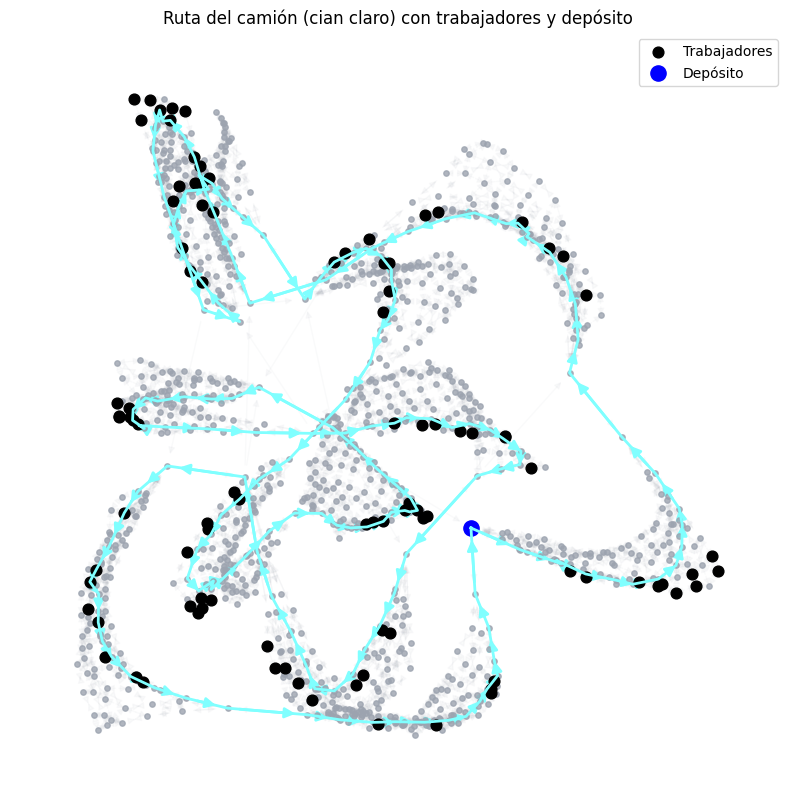

In [17]:
import sys
import argparse
import heapq
import random
import pandas as pd
from collections import defaultdict
random.seed(33)

# Configuración global
DEPOT = 0
IS_DIRECTED = True
RETURN_TO_DEPOT = True
TIE_BREAK_RANDOM = True
HOME_COLS = ["home", "hogar", "node", "nodo", "cliente", "vi"]

### Sección construcción

def pick_col(df, candidates, alias="home"):
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"No se encontró columna para {alias}. Columnas: {list(df.columns)}")

def build_adj_with_weights(path, directed=True):
    df = pd.read_csv(path, header=None, names=["u", "v", "w"])
    adj = defaultdict(list)
    wmap = {}
    for _, r in df.iterrows():
        u, v, w = int(r.u), int(r.v), float(r.w)
        adj[u].append(v)
        wmap[(u, v)] = w
        if not directed:
            adj[v].append(u)
            wmap[(v, u)] = w
    return adj, wmap

def bfs_radius(adj, wmap, start, radius):
    heap = [(0.0, start)]
    dist = {start: 0.0}
    result = set()
    while heap:
        d, u = heapq.heappop(heap)
        if d > radius + 1e-12:
            continue
        result.add(u)
        for v in adj.get(u, []):
            nd = d + wmap[(u, v)]
            if v not in dist or nd < dist[v] - 1e-12:
                dist[v] = nd
                heapq.heappush(heap, (nd, v))
    return result

def dijkstra_to_any(adj, wmap, src, target_nodes):
    heap = [(0.0, src)]
    dist = {src: 0.0}
    parent = {src: None}
    best_cost = None
    found_targets = []

    while heap:
        du, u = heapq.heappop(heap)
        if du != dist[u]:
            continue
        if best_cost is not None and du > best_cost + 1e-12:
            break
        if u in target_nodes:
            if best_cost is None:
                best_cost = du
            found_targets.append(u)
        for v in adj.get(u, []):
            nd = du + wmap[(u, v)]
            if v not in dist or nd < dist[v] - 1e-12:
                dist[v] = nd
                parent[v] = u
                heapq.heappush(heap, (nd, v))

    if not found_targets:
        return None, None, None

    chosen = random.choice(found_targets) if (TIE_BREAK_RANDOM and len(found_targets) > 1) else found_targets[0]

    path = []
    cur = chosen
    while cur is not None:
        path.append(cur)
        cur = parent[cur]
    path.reverse()
    return chosen, path, best_cost

def solve_with_walks(adj, wmap, workers_info):
    worker_to_nodes = {}
    for home, rad in workers_info:
        nodes = bfs_radius(adj, wmap, home, rad)
        worker_to_nodes[home] = nodes

    remaining_workers = set(worker_to_nodes.keys())
    route = [DEPOT]
    segments = []
    unreachable = []
    current = DEPOT
    total_cost = 0.0

    while remaining_workers:
        candidate_nodes = set()
        node_to_workers = defaultdict(list)

        for w in remaining_workers:
            for n in worker_to_nodes[w]:
                candidate_nodes.add(n)
                node_to_workers[n].append(w)

        target_node, path, seg_cost = dijkstra_to_any(adj, wmap, current, candidate_nodes)
        if target_node is None:
            unreachable.extend(sorted(list(remaining_workers)))
            break

        route.extend(path[1:])
        segments.append({
            "from": current,
            "to": target_node,
            "segment_cost": float(seg_cost),
            "nodes": " ".join(map(str, path))
        })
        total_cost += float(seg_cost)
        current = target_node

        for w in node_to_workers[target_node]:
            if w in remaining_workers:
                remaining_workers.remove(w)

    if RETURN_TO_DEPOT:
        target, path_back, cost_back = dijkstra_to_any(adj, wmap, current, {DEPOT})
        if target is not None:
            route.extend(path_back[1:])
            total_cost += float(cost_back)
            segments.append({
                "from": current,
                "to": DEPOT,
                "segment_cost": float(cost_back),
                "nodes": " ".join(map(str, path_back))
            })

    return route, segments, total_cost, unreachable, set(worker_to_nodes.keys())

### Sección mejora

def random_node_swap(adj, wmap, route, worker_to_nodes, p_accept=0.2):
    if len(route) < 4:
        return route, 0.0

    def route_cost(r):
        cost = 0.0
        for i in range(len(r)-1):
            if (r[i], r[i+1]) in wmap:
                cost += wmap[(r[i], r[i+1])]
            else:
                return float('inf')
        return cost

    def is_feasible(r):
        route_nodes = set(r)
        for worker, reachable in worker_to_nodes.items():
            if not route_nodes.intersection(reachable):
                return False
        return True

    best_route = route[:]
    best_cost = route_cost(best_route)

    non_depot_indices = [i for i in range(len(route)) if route[i] != 0]

    for _ in range(len(non_depot_indices)*2):
        i, j = random.sample(non_depot_indices, 2)
        new_route = best_route[:]
        new_route[i], new_route[j] = new_route[j], new_route[i]

        if is_feasible(new_route):
            new_cost = route_cost(new_route)
            if new_cost < best_cost or random.random() < p_accept:
                best_route = new_route
                best_cost = new_cost

    return best_route, route_cost(route) - best_cost

def remove_redundant_nodes(adj, wmap, route, worker_to_nodes):
    if len(route) < 4:
        return route, 0.0

    def route_cost(r):
        cost = 0.0
        for i in range(len(r) - 1):
            if (r[i], r[i+1]) in wmap:
                cost += wmap[(r[i], r[i+1])]
            else:
                return float('inf')
        return cost

    def workers_served_by_route(r):
        route_nodes = set(r)
        served = set()
        for worker, reachable_nodes in worker_to_nodes.items():
            if route_nodes.intersection(reachable_nodes):
                served.add(worker)
        return served

    original_cost = route_cost(route)
    original_served = workers_served_by_route(route)
    best_route = route[:]

    for i in range(len(route)):
        if route[i] == DEPOT:
            continue
        test_route = route[:i] + route[i+1:]
        if len(test_route) < 2:
            continue
        served_workers = workers_served_by_route(test_route)
        if len(served_workers) == len(original_served):
            new_cost = route_cost(test_route)
            if new_cost < route_cost(best_route):
                best_route = test_route[:]

    return best_route, original_cost - route_cost(best_route)

def local_search_improvement(adj, wmap, route, worker_to_nodes, max_time_seconds=30):
    import time
    start_time = time.time()

    def route_cost(r):
        cost = 0.0
        for i in range(len(r) - 1):
            if (r[i], r[i+1]) in wmap:
                cost += wmap[(r[i], r[i+1])]
            else:
                return float('inf')
        return cost

    current_route = route[:]
    original_cost = route_cost(current_route)
    total_improvement = 0.0
    iteration = 0

    while time.time() - start_time < max_time_seconds and iteration < 20:
        iteration += 1
        improved_this_iteration = False

        improved_route, improvement = remove_redundant_nodes(adj, wmap, current_route, worker_to_nodes)
        if improvement > 0.001:
            current_route = improved_route
            total_improvement += improvement
            improved_this_iteration = True

        improved_route, improvement = random_node_swap(adj, wmap, current_route, worker_to_nodes, p_accept=0.2)
        if improvement > 0.001:
            current_route = improved_route
            total_improvement += improvement
            improved_this_iteration = True

        if not improved_this_iteration:
            break

    final_cost = route_cost(current_route)
    return current_route, total_improvement

### Adaptación para Colab

def main():
    import matplotlib.pyplot as plt
    import networkx as nx

    # Simulación de argumentos
    sys.argv = ["Tarea1m.py", "datasetFinal/grafo.csv", "datasetFinal/instancia1.csv"]

    parser = argparse.ArgumentParser(description="Ruteo de vehículos con caminatas usando Dijkstra + mejoras locales")
    parser.add_argument("grafo", help="Archivo CSV del grafo (formato: u,v,w)")
    parser.add_argument("instancia", help="Archivo CSV de la instancia (formato: home,radius)")
    parser.add_argument("--no-improvement", action="store_true", help="Saltar mejoras locales")
    parser.add_argument("--max-time", type=int, default=30, help="Tiempo máximo para mejoras (segundos)")

    args = parser.parse_args()

    # Construir grafo
    adj, wmap = build_adj_with_weights(args.grafo, directed=IS_DIRECTED)
    Gx = nx.DiGraph() if IS_DIRECTED else nx.Graph()
    for u, neighs in adj.items():
        for v in neighs:
            Gx.add_edge(u, v, w=wmap[(u, v)])

    # Instancia
    df_inst = pd.read_csv(args.instancia, header=None, names=["home", "radius"])
    home_col = pick_col(df_inst, HOME_COLS, alias="nodo del trabajador")
    workers_info = [(int(r[home_col]), float(r["radius"])) for _, r in df_inst.iterrows()]
    workers_info = [(h, r) for h, r in workers_info if h != DEPOT]
    workers = [w for w, _ in workers_info]

    # Construcción
    route, segments, total_cost, unreachable, workers_set = solve_with_walks(adj, wmap, workers_info)
    initial_cost = total_cost

    # Mejora
    if not args.no_improvement and len(route) > 3:
        worker_to_nodes = {}
        for home, rad in workers_info:
            nodes = bfs_radius(adj, wmap, home, rad)
            worker_to_nodes[home] = nodes
        improved_route, total_improvement = local_search_improvement(
            adj, wmap, route, worker_to_nodes, max_time_seconds=args.max_time
        )
        if total_improvement > 0.001:
            route = improved_route
            total_cost = 0.0
            for i in range(len(route) - 1):
                if (route[i], route[i+1]) in wmap:
                    total_cost += wmap[(route[i], route[i+1])]

    # Verificación de factibilidad
    atendidos = len(workers_set) - len(unreachable)
    factible = atendidos == len(workers_set)

    # --- Reporte ---
    print("\n--- Resultado final ---")
    print(f"Costo inicial (sin mejoras): {initial_cost:.3f}")
    print(f"Costo final (con mejoras): {total_cost:.3f}")
    print(f"Factible: {'Sí, todos atendidos' if factible else f'No, faltan {len(unreachable)}'}")

    # --- Gráfico ---
    pos = nx.spring_layout(Gx, seed=33)

    plt.figure(figsize=(10,10))
    # Grafo base (gris)
    nx.draw_networkx_edges(Gx, pos, alpha=0.05, arrows=IS_DIRECTED, edge_color="#9CA3AF")
    nx.draw_networkx_nodes(Gx, pos, node_size=15, node_color="#9CA3AF", alpha=0.8)

    # Trabajadores (negros)
    nx.draw_networkx_nodes(Gx, pos, nodelist=workers, node_size=60, node_color="black", label="Trabajadores")

    # Depósito (azul fuerte)
    nx.draw_networkx_nodes(Gx, pos, nodelist=[DEPOT], node_size=120, node_color="blue", label="Depósito")

    # Ruta del camión (cian claro)
    path_edges = [(route[i], route[i+1]) for i in range(len(route)-1)]
    nx.draw_networkx_edges(Gx, pos, edgelist=path_edges, edge_color="#80ffff", width=2, arrows=IS_DIRECTED, arrowsize=15)

    xs = [pos[n][0] for n in route]
    ys = [pos[n][1] for n in route]
    plt.plot(xs, ys, color="#80ffff", linewidth=2)

    plt.title("Ruta del camión (cian claro) con trabajadores y depósito")
    plt.axis("off")
    plt.legend(loc="upper right")
    plt.show()

# Ejecutar directamente
main()


## Construcción (Greedy con caminatas)

Para la fase de construcción utilizamos una heurística golosa tipo *Nearest Neighbor (NN)* adaptada al problema con caminatas:

1. Arrancamos en el depósito.
2. Siempre vamos al nodo más cercano que permita atender a uno o más trabajadores (con Dijkstra).
3. Cuando llegamos, marcamos como atendidos a todos los trabajadores que puedan caminar hasta ese nodo.
4. Repetimos hasta atender a todos.
5. Finalmente, la van retorna al depósito.

Esta construcción corresponde a lo visto en clase como **heurística golosa de construcción**.

---

## Mejoras locales aplicadas

Tras obtener la solución inicial, aplicamos una fase de mejora local (*Variable Neighborhood Descent*), compuesta por:

- **Eliminación de nodos redundantes**:  
  Se eliminan de la ruta aquellos nodos cuya visita no aporta nuevos trabajadores atendidos.  
  → Reduce la longitud total de la ruta sin perder factibilidad.  
  → Relacionado con la purga de clientes redundantes vista en clase.

- **Swap aleatorio**:  
  Se seleccionan dos nodos al azar y se intercambian.  
  - Si la solución mejora, se acepta.  
  - Si no mejora, puede aceptarse con probabilidad `p_accept` (*componente aleatorio estilo Simulated Annealing*).  
  → Esto permite escapar de óptimos locales.

- **Iterative local search (multi-vecindario / VND)**:  
  Se combinan ambas operaciones en un bucle hasta que no se encuentran más mejoras o se alcanza un límite de tiempo.  
  → Relacionado con *Variable Neighborhood Descent* (VND) visto en clase.

---

## Pruebas adicionales

Además de la combinación anterior, probamos aplicar otras heurísticas y metaheurísticas:

- **2-opt** (intercambio de aristas para eliminar cruces).  
- **Reinserción de nodos** (mover un nodo a otra posición en la ruta).  
- **Simulated Annealing (SA)** con esquema de temperatura decreciente.  
- **Tabu Search** con memoria de soluciones recientes.

En nuestras instancias, estas variantes **no lograron mejoras significativas** respecto a la estrategia de:
**Greedy con caminatas + eliminación de nodos redundantes + swap aleatorio**,  
por lo que reportamos únicamente los resultados obtenidos con dicha combinación.

---

# En resumen hicimos :

- **Construcción**: Greedy con caminatas (Nearest Neighbor adaptado).  
- **Mejoras**:  
  - Eliminación de nodos redundantes.  
  - Swap aleatorio con aceptación probabilística.  
  - Búsqueda local iterativa (VND).  
- **Exploración adicional**: probamos 2-opt, reinserción, SA y Tabu, pero no aportaron mejoras significativas.


## Variante con penalización

En esta variante:

- Podemos **no atender a algunos trabajadores**.
- Eso **no rompe la factibilidad** de la solución.
- Pero cada trabajador no recogido genera un **costo extra** (penalización fija o proporcional).
- El objetivo ahora es minimizar:

\[
\text{costo total} = \text{costo de la ruta} \;+\; \text{penalización} \times (\# \text{trabajadores no atendidos})
\]



**Idea de implementación**

1. Correr la heurística inicial y obtener el costo original atendiendo a todos los trabajadores.

2. Para cada trabajador `i`:
   - Simular la ruta sin atender a `i`.
   - Penalizar con un valor fijo `P`.
   - Calcular el nuevo costo:  
     \[
     \text{costo\_nuevo} = \text{costo\_ruta\_sin\_i} + P
     \]
   - Si ese costo es menor que el original, guardar la solución como la mejor encontrada.

3. Repetir el proceso quitando más de un trabajador (en combinaciones), hasta que el costo total deje de mejorar.

Osea esta heurística sigue siendo la misma, pero ahora permite sacrificar la atención de algunos trabajadores si el costo de recorrerlos es más alto que pagar la penalización.

